In [1]:
from detecto import core, utils, visualize
import cv2

c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model from file id_card_4_corner.pth 
model = core.Model.load('./model/id_card_4_corner.pth', ['top_left', 'top_right', 'bottom_left', 'bottom_right'])

c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
fname = "./cccd2.jpg"
image = utils.read_image(fname)


In [4]:
# convert image to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
labels, boxes, scores = model.predict(image)


In [6]:
print(labels)

['bottom_left', 'top_left', 'bottom_right', 'top_right', 'bottom_left']


In [7]:
import cv2

for i, bbox in enumerate(boxes):
    bbox = list(map(int, bbox))
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(0,255,0),2)
    cv2.putText(image, labels[i], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))


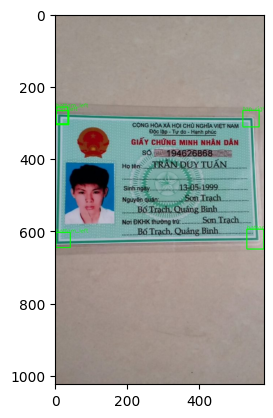

In [8]:
# show image by plt
import matplotlib.pyplot as plt

plt.imshow(image)

In [9]:
import numpy as np 

def non_max_suppression_fast(boxes, labels, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #  
    # initialize the list of picked indexes   
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
         np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    
    return final_boxes, final_labels


In [10]:
final_boxes, final_labels = non_max_suppression_fast(np.array(boxes), labels, 0.3) 

In [11]:
def get_center_point(box):
    xmin, ymin, xmax, ymax = box
    return (xmin + xmax) // 2, (ymin + ymax) // 2


In [12]:
final_points = list(map(get_center_point, final_boxes))


In [13]:
label_boxes = dict(zip(final_labels, final_points))

In [14]:
def perspective_transoform(image, source_points):
    dest_points = np.float32([[0,0], [500,0], [500,300], [0,300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (500, 300))
    
    return dst


In [15]:
# isset label_boxes['bottom_right']
if 'top_right' in label_boxes:
    print("hi")


hi


In [16]:
source_points = np.float32([
    label_boxes['top_left'], label_boxes['top_right'], label_boxes['bottom_right'], label_boxes['bottom_left']
])

# Transform 
crop = perspective_transoform(image, source_points)


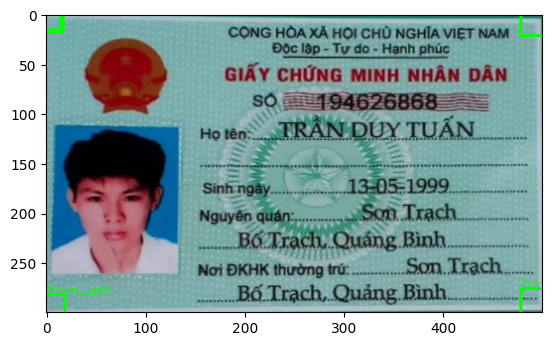

In [17]:
plt.imshow(crop)

In [18]:
# save image crop
cv2.imwrite('crop.jpg', crop)

True

In [19]:
# import Craft 
from craft_text_detector import Craft

In [20]:
# load model
craft = Craft()


c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
prediction_resultprediction_result = craft.detect_text('crop.jpg')

c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\craft_text_detector\craft_utils.py:415: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys = np.array(polys)
c:\Users\congp\AppData\Local\Programs\Python\Python39\lib\site-packages\craft_text_detector\predict.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polys_as_ratio = np.array(polys_as_ratio)


In [22]:
#